**Setup** <br> In this part the important packages and the data are going to be imported. The data is going to be preprocessed, so we are able to work with it.

In [2]:
# importing all the necessary packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns
from sklearn.neural_network import MLPRegressor # neural network that is going to be used
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_absolute_error

In [5]:
# importing the data and splitting it into a train and test set to work with
# important!! use index_col=0 to read df otherwise pca starts at col 58
ped = pd.read_csv("data_clean_with_dummies.csv", index_col=0)

# beginning of the code, so everyone has the same data, for reproduceability
np.random.seed(1) 

# Define a new X with the squared feature k = 0.99, 57+46
X = np.array(ped[ped.columns[57:103]])

# Output to predict
y = ped["pedestrians count"]

# Split the dataset into train and test sets
Xtrain, Xtest, ytrain, ytest = train_test_split(
    X, y, test_size=0.3, random_state=72)

**Hyperparameter tuning** <br> The different hyperparameters of the used function for our neural netwwork (MLPRegressor by sklearn) are being optimized. <br> 1. Establish a base scenario with the standard parameters to compare afterwards. <br> 2. Analyze the influence of the different parameters of MLPRegressor if every other parameter is in default. <br> 3. Trying to find the best parameters using RandomizedSearchCV and GridSearchCV using subsamples of the data.

*1. Establish Base Scenario*

In [6]:
# initialize a neural network with the default parameters 
nnet_base = MLPRegressor()

In [7]:
# scale the data to work so it is less sensitive to feature scaling 
scaler = StandardScaler()
# scale the inputs
scaler.fit(Xtrain)
Xtrain_scaled = scaler.transform(Xtrain)
# apply the same transformation to the test data to have meaningful results
Xtest_scaled = scaler.transform(Xtest)
# scale the y different because we can't use standardscaler to a 1d array
mu, sigma = y.mean(), y.std()
ytest_scaled = (ytest - mu) / sigma
ytrain_scaled = (ytrain - mu) /sigma

In [8]:
# Fit the network to the scaled train data
nnet_base.fit(Xtrain_scaled, ytrain_scaled)

# Make predictions
ypred_train_scaled = nnet_base.predict(Xtrain_scaled)
ypred_scaled = nnet_base.predict(Xtest_scaled)

# Reconstruct outputs and scale back predictions
ytest = ytest_scaled * sigma + mu
ytrain = ytrain_scaled * sigma + mu
ypred_train = ypred_train_scaled * sigma + mu
ypred = ypred_scaled * sigma + mu
# the network predicts negative values because it is not possible to put an activation function on the output layer
# MLPRegressor uses the activation function only on the hidden layers
# Negative Values make no sense in our case, therefore we fix it and tell the network that all negative values
# should equal to zero
ypred[ypred < 0] = 0

# Compute the MAE
mae_train = mean_absolute_error(ytrain, ypred_train)
mae_test = mean_absolute_error(ytest, ypred)
# Comute R^2
r2_train = r2_score(ytrain, ypred_train)
r2_test = r2_score(ytest, ypred)

print(f"The mean absolute error of the training data is {mae_train:>10.2f}")
print(f"The R^2 of the training data is {r2_train:>10.2f}")
print(20 * "*")
print(f"The mean absolute error of the testing data is {mae_test:>10.2f}")
print(f"The R^2 of the testing data is {r2_test:>10.2f}")

The mean absolute error of the training data is     347.45
The R^2 of the training data is       0.96
********************
The mean absolute error of the testing data is     449.06
The R^2 of the testing data is       0.94


*Results:* <br> The mean absolute error of the training data is 347.45 <br>
The R^2 of the training data is 0.96 <br>
******************** <br>
The mean absolute error of the testing data is 449.06 <br>
The R^2 of the testing data is 0.94

*2. Analyze the Influence of the Different Parameters*

In [10]:
# conduncting the parameter analysis on the most used parameters for optimization
# how many hidden layers with how many neurons are we going to use
# 100 is the default value, other values chosen randomly to see the effect of more layers
hidden_layer_sizes = [(100,), (32, 64, 32), (64, 128, 64), (32, 64, 128, 64, 32)]
# activation function that is going to be used on the hidden layers, relu is the default value
activations = ["relu", "logistic", "tanh", "identity"]
# the solver which optimizes the weights, adam is the default value
solvers = ["sgd", "adam"]
# regularization: avoids overfitting, 0.0001 is the default value
alphas = np.linspace(0.00001, 0.001, 50)
# how high is the initial learing rate, 0.001 is the default value
learing_rate_inits = np.linspace(0.001, 0.01, 50)
# number of epochs, 200 is the default value
# often it doesn't converge then so we start at 1000
max_iters = range(1000, 2000, 20)

In [11]:
# creating a dataframe to save the results
results = pd.DataFrame(columns=["Parameter", "ParameterValue", "MaeTrain", "MaeTest", "R2Train", "R2Test"])

# defining a function to do the analysis on the different parameters
def test_parameter(param, param_values, initialize_model):
    global results
    for param_value in param_values:
        nnet_param = initialize_model(param_value)
        # Fit the network to the train data
        nnet_param.fit(Xtrain_scaled, ytrain_scaled)
        # Make predictions
        ypred_param_train_scaled = nnet_param.predict(Xtrain_scaled)
        ypred_param_scaled = nnet_param.predict(Xtest_scaled)

        # Reconstruct outputs and scale predictions
        ypred_param_train = ypred_param_train_scaled * sigma + mu
        ypred_param = ypred_param_scaled * sigma + mu
        ypred_param[ypred_param < 0] = 0 # all neg values equal zero to make sense
        
        # Compute the MAE
        mae_param_train = mean_absolute_error(ytrain, ypred_param_train)
        mae_param_test = mean_absolute_error(ytest, ypred_param)
        # Comute R^2
        r2_param_train = r2_score(ytrain, ypred_param_train)
        r2_param_test = r2_score(ytest, ypred_param)

        # adding the calculated reults to the dataframe
        row = pd.DataFrame(data=[[param, param_value, mae_param_train, mae_param_test, r2_param_train, r2_param_test]],
        columns=["Parameter", "ParameterValue", "MaeTrain", "MaeTest", "R2Train", "R2Test"])
        results = pd.concat([results, row])

# apply the function to the different parameters
test_parameter("hidden_layer_size", hidden_layer_sizes, lambda value: MLPRegressor(hidden_layer_sizes=value, random_state=72))
test_parameter("activation", activations, lambda value: MLPRegressor(activation=value, random_state=72))
test_parameter("solver", solvers, lambda value: MLPRegressor(solver=value, random_state=72))
test_parameter("alpha", alphas, lambda value: MLPRegressor(alpha=value, random_state=72))
test_parameter("learning_rate_init", learing_rate_inits, lambda value: MLPRegressor(learning_rate_init=value, random_state=72))
test_parameter("max_iter", max_iters, lambda value: MLPRegressor(max_iter=value, random_state=72))

# merging results into dataframe and safe it as csv to work with it later on
results = results.reset_index().drop(columns="index")
results.to_csv("param_testing_nnet.csv", sep=";", index=False)

In [12]:
# reading the created dataframe and have a look at it to plot it later for the analysis
param_testing = pd.read_csv("param_testing_nnet.csv", sep=";")
param_testing

,Parameter,ParameterValue,MaeTrain,MaeTest,R2Train,R2Test
0,hidden_layer_size,"(100,)",347.696832,437.135880,0.964892,0.943203
1,hidden_layer_size,"(32, 64, 32)",297.319744,427.635196,0.972019,0.931630
2,hidden_layer_size,"(64, 128, 64)",297.511867,427.921575,0.973874,0.927907
3,hidden_layer_size,"(32, 64, 128, 64, 32)",244.434975,442.420122,0.979625,0.921200
4,activation,relu,347.696832,437.135880,0.964892,0.943203
...,...,...,...,...,...,...
155,max_iter,1900,347.696832,437.135880,0.964892,0.943203
156,max_iter,1920,347.696832,437.135880,0.964892,0.943203
157,max_iter,1940,347.696832,437.135880,0.964892,0.943203
158,max_iter,1960,347.696832,437.135880,0.964892,0.943203


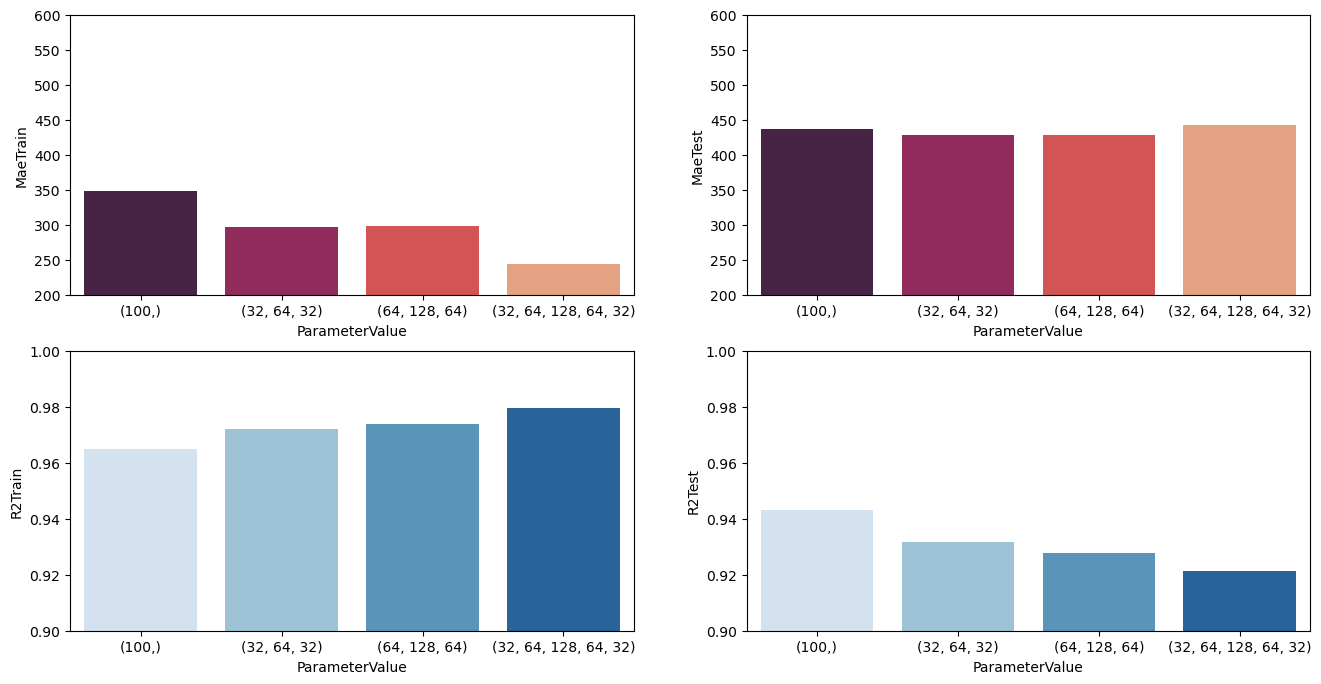

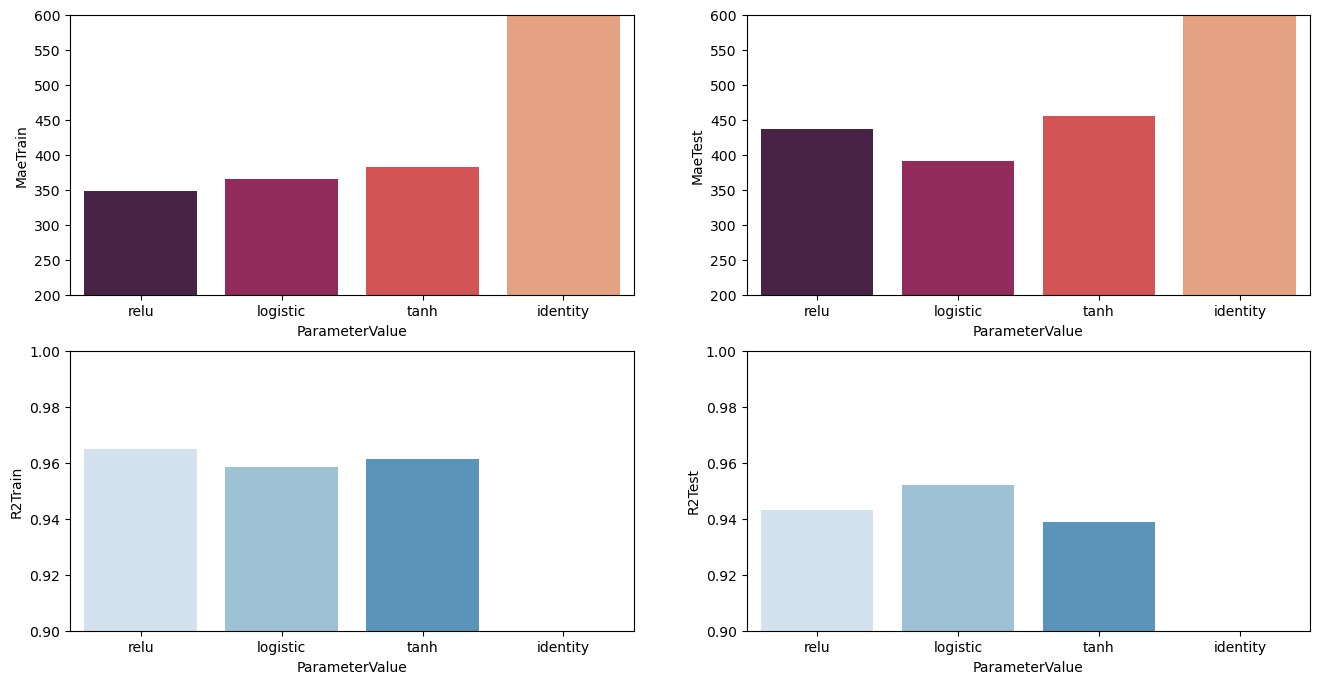

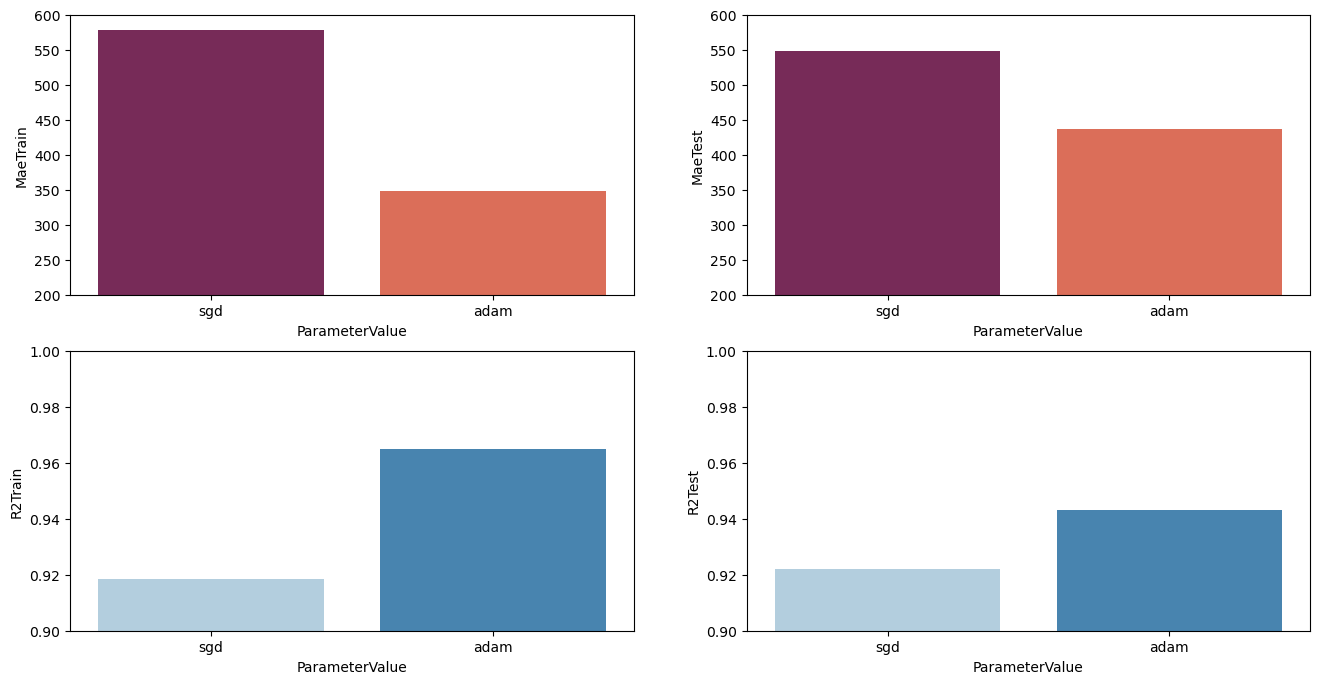

In [14]:
# defining a function for barplots for some of the parameters to compare mae and r2
def plot_bars(data_filter):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 8))
    plot_data = param_testing[param_testing["Parameter"] == data_filter]

    mae_train_axes = axes[0, 0]
    sns.barplot(data=plot_data, x="ParameterValue", y="MaeTrain", ax=mae_train_axes, palette="rocket")
    mae_train_axes.set_ylim(200, 600)

    mae_test_axes = axes[0, 1]
    sns.barplot(data=plot_data, x="ParameterValue", y="MaeTest", ax=mae_test_axes, palette="rocket")
    mae_test_axes.set_ylim(200, 600)

    r2_train_axes = axes[1, 0]
    sns.barplot(data=plot_data, x="ParameterValue", y="R2Train", ax=r2_train_axes, palette="Blues")
    r2_train_axes.set_ylim(0.9, 1)

    r2_test_axes = axes[1, 1]
    sns.barplot(data=plot_data, x="ParameterValue", y="R2Test", ax=r2_test_axes, palette="Blues")
    r2_test_axes.set_ylim(0.9, 1)

# apply the function to wanted parameters for comparison
plot_bars("hidden_layer_size")
plot_bars("activation")
plot_bars("solver")

*Interpretation:* <br> - Hidden Layers: It can be seen that "(100,)" or "(32, 64, 32)" are the best parameters while analyzing MAE and R^2 <br> - Activation: Clearly "Relu" or "Logistic" should be used as an activation function. <br> - Solver: "Adam" is the better solver on the training an the testing data.

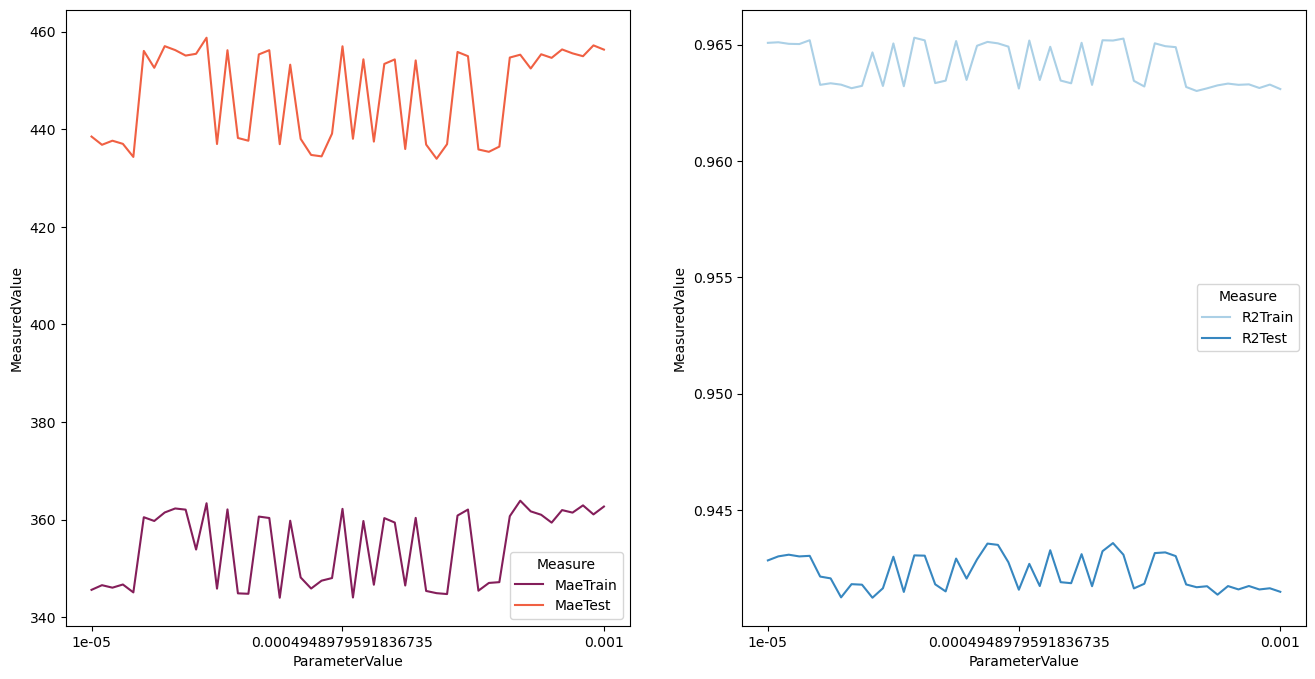

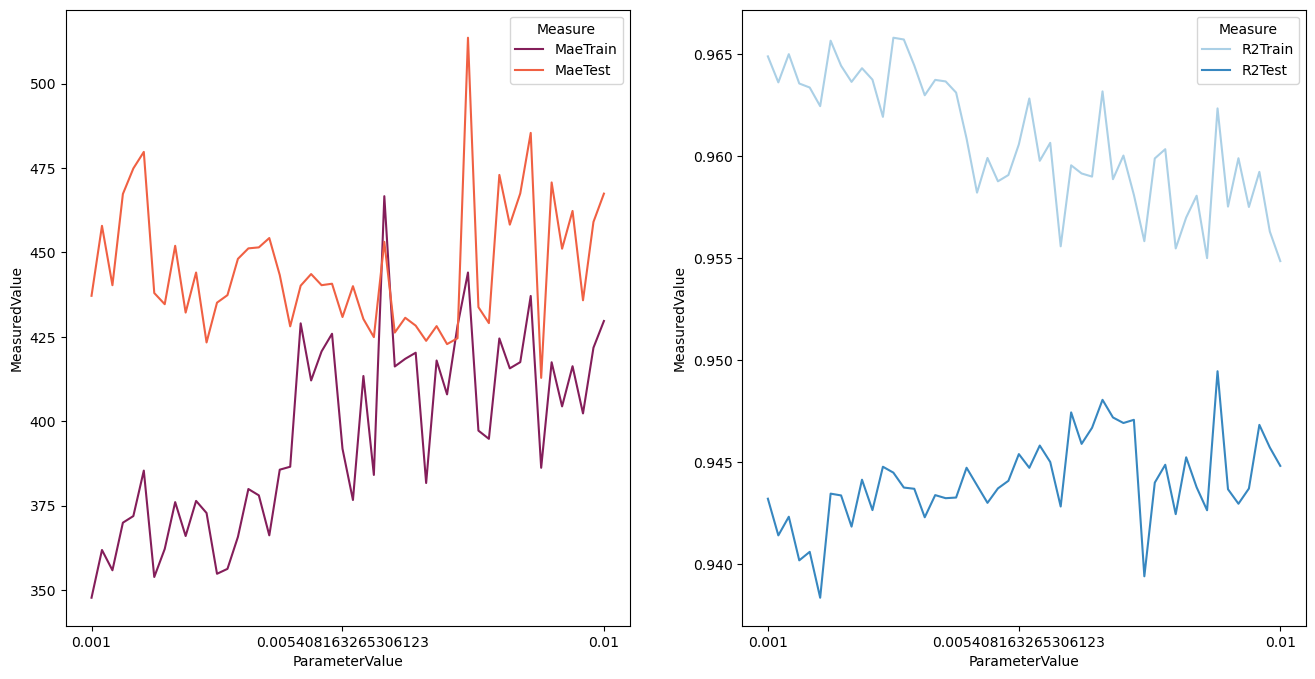

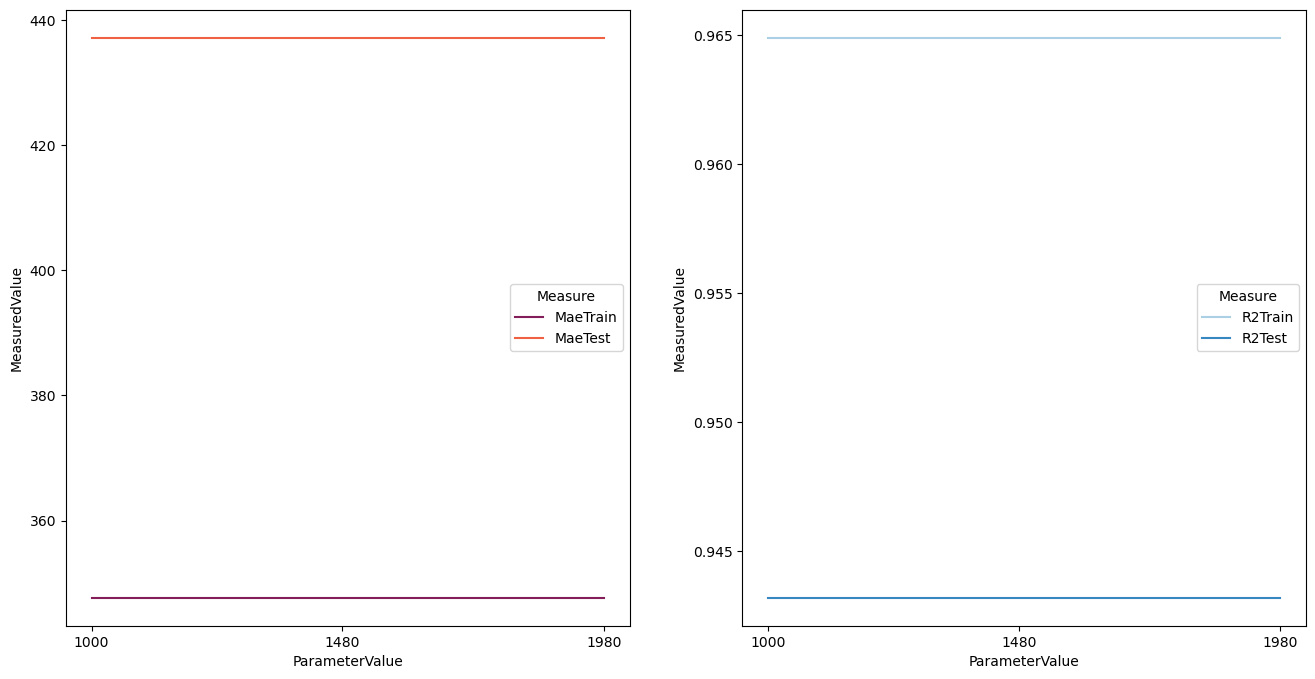

In [15]:
# defining a function for lineplots for some of the parameters to compare mae and r2
def plot_lines(data_filter):
    fig, axes = plt.subplots(ncols=2, figsize=(16, 8))
    plot_data = param_testing[param_testing["Parameter"] == data_filter]
    plot_data = pd.melt(plot_data, id_vars=["Parameter", "ParameterValue"], var_name="Measure", 
    value_vars=["MaeTrain", "MaeTest", "R2Train", "R2Test"], value_name="MeasuredValue")

    mae_data = plot_data[plot_data["Measure"].isin(["MaeTrain", "MaeTest"])]
    mae_axes = axes[0]
    sns.lineplot(data=mae_data, x="ParameterValue", y="MeasuredValue", hue="Measure", ax=mae_axes, palette="rocket")
    mae_axes.set_xticks([0, 24, 49])

    r2_data = plot_data[plot_data["Measure"].isin(["R2Train", "R2Test"])]
    r2_axes = axes[1]
    sns.lineplot(data=r2_data, x="ParameterValue", y="MeasuredValue", hue="Measure", ax=r2_axes, palette="Blues")
    r2_axes.set_xticks([0, 24, 49])

# apply the function to wanted parameters for comparison
plot_lines("alpha")
plot_lines("learning_rate_init")
plot_lines("max_iter")

*Interpretation:* <br> - Alpha: It should be somewhere in the middle of 0.00001 and 0.001, so the default value of 0.0001 doesn't seem to be too bad <br> - Learning Rate: A good learning rate seems to be around 0.001, like the default value. Maybe we should event try something smaller <br> - Iterations: There is no different in using 1000 or 2000 iterations, so we are going with 1000 for faster results

In [77]:
# scale the data so it is less sensitive to feature scaling
scaler = StandardScaler()
# scale the inputs
scaler.fit(X)
X = scaler.transform(X)

# scale the y different because we can't use standardscaler to a 1d array
mu, sigma = y.mean(), y.std() # We will use this to scale back to original values!
y = (y - mu) / sigma

scorers = ["r2", "neg_mean_absolute_error"]

parameters= {
    "hidden_layer_sizes": [(32, 64, 32), (64, 128, 64), (32, 64, 128, 64, 32)],
    "activation": ["tanh", "relu"],
    "solver": ["sgd", "adam"],
    "alpha": [0.0001, 0.0005, 0.00005],
    "learning_rate_init" : [0.001, 0.01],
    "max_iter" : [1000, 2000]
}

model1 = GridSearchCV(MLPRegressor(), parameters, cv=5, scoring=scorers, refit=False)
model1.fit(X, y)

results = pd.DataFrame()
params = model1.cv_results_["params"]

maes = model1.cv_results_["mean_test_neg_mean_absolute_error"]
r2s = model1.cv_results_["mean_test_r2"]

results["Params"] = pd.Series(params)
results["MeanMAE"] = pd.Series(maes)
results["MeanR2"] = pd.Series(r2s)

results.sort_values("MeanR2", inplace=True)

results.to_csv("results_nnet_gs.csv", sep=";", index=False)

results

,Params,MeanMAE,MeanR2
2,"{'activation': 'tanh', 'alpha': 0.0001, 'hidde...",-0.472892,-0.211405
10,"{'activation': 'tanh', 'alpha': 0.0001, 'hidde...",-0.448034,0.007808
36,"{'activation': 'tanh', 'alpha': 0.0005, 'hidde...",-0.430489,0.042200
62,"{'activation': 'tanh', 'alpha': 5e-05, 'hidden...",-0.408989,0.088827
14,"{'activation': 'tanh', 'alpha': 0.0001, 'hidde...",-0.404322,0.089468
...,...,...,...
125,"{'activation': 'relu', 'alpha': 5e-05, 'hidden...",-0.169166,0.890692
85,"{'activation': 'relu', 'alpha': 0.0001, 'hidde...",-0.176035,0.891088
45,"{'activation': 'tanh', 'alpha': 0.0005, 'hidde...",-0.163545,0.891118
117,"{'activation': 'relu', 'alpha': 0.0005, 'hidde...",-0.154815,0.895262


In [91]:
# modelling the MLPRegressor with best parameters
# importing the data and splitting it to work with
# important!! use index_col=0 to read df otherwise pca starts at col 58
ped = pd.read_csv("data_clean_with_dummies.csv", index_col=0)

# beginning of the code, so everyone has the same
np.random.seed(1) # Set the random seed for reproduceability

# Define a new X with the squared feature k = 0.99, 57+46
X = np.array(ped[ped.columns[57:103]])

# Output to predict
y = ped["pedestrians count"]

# Split the dataset into train and test sets
Xtrain, Xtest, ytrain, ytest = train_test_split(
    X, y, test_size=0.3, random_state=72)

In [92]:
# initialize a neural network with the standard parameters 
nnet_optimization = MLPRegressor(hidden_layer_sizes=(32, 64, 32), activation="relu", solver="adam",
                    alpha=0.0001, learning_rate_init=0.01, max_iter=1000)

In [93]:
# scale the data to work so it is less sensitive to feature scaling 
scaler = StandardScaler()
# scale the inputs
scaler.fit(Xtrain)
Xtrain = scaler.transform(Xtrain)
# apply the same transformation to the test data to have meaningful results
Xtest = scaler.transform(Xtest)
# scale the y different because we can't use standardscaler to a 1d array
mu, sigma = y.mean(), y.std() # We will use this to scale back to original values!
ytest = (ytest - mu) / sigma
ytrain = (ytrain - mu) /sigma

In [94]:
# Fit the network to the train data
nnet_optimization.fit(Xtrain, ytrain)

# Make predictions
ypred_train = nnet_optimization.predict(Xtrain)
ypred = nnet_optimization.predict(Xtest)

# Reconstruct outputs and scale predictions
ytest = ytest * sigma + mu
ytrain = ytrain * sigma + mu
ypred_train = ypred_train * sigma + mu
ypred = ypred * sigma + mu

# Compute the MAE
mae_train = mean_absolute_error(ytrain, ypred_train)
mae_test = mean_absolute_error(ytest, ypred)
# Comute R^2
r2_train = r2_score(ytrain, ypred_train)
r2_test = r2_score(ytest, ypred)

print(f"The mean absolute error of the training data is {mae_train:>10.2f}")
print(f"The R^2 of the training data is {r2_train:>10.2f}")
print(20 * "*")
print(f"The mean absolute error of the testing data is {mae_test:>10.2f}")
print(f"The R^2 of the testing data is {r2_test:>10.2f}")

The mean absolute error of the training data is     339.24
The R^2 of the training data is       0.96
********************
The mean absolute error of the testing data is     399.66
The R^2 of the testing data is       0.94


*Results:* <br> The mean absolute error of the training data is 339.24 <br>
The R^2 of the training data is 0.96 <br>
******************** <br>
The mean absolute error of the testing data is 400.66 <br>
The R^2 of the testing data is 0.94

In [95]:
# scale the data so it is less sensitive to feature scaling
scaler = StandardScaler()
# scale the inputs
scaler.fit(X)
X = scaler.transform(X)

# scale the y different because we can't use standardscaler to a 1d array
mu, sigma = y.mean(), y.std() # We will use this to scale back to original values!
y = (y - mu) / sigma

scorers = ["r2", "neg_mean_absolute_error"]

parameters= {
    "hidden_layer_sizes": [(32, 64, 32), (100,)],
    "activation": ["relu"],
    "solver": ["adam"],
    "alpha": [0.0001],
    "learning_rate_init" : [0.001],
    "batch_size" : [16, 32, 64],
    "max_iter" : [1000]
}

model1 = GridSearchCV(MLPRegressor(), parameters, cv=5, scoring=scorers, refit=False)
model1.fit(X, y)

results = pd.DataFrame()
params = model1.cv_results_["params"]

maes = model1.cv_results_["mean_test_neg_mean_absolute_error"]
r2s = model1.cv_results_["mean_test_r2"]

results["Params"] = pd.Series(params)
results["MeanMAE"] = pd.Series(maes)
results["MeanR2"] = pd.Series(r2s)

results.sort_values("MeanR2", inplace=True)

results.to_csv("results_nnet_gs2.csv", sep=";", index=False)

results

,Params,MeanMAE,MeanR2
1,"{'activation': 'relu', 'alpha': 0.0001, 'batch...",-0.340388,0.570843
5,"{'activation': 'relu', 'alpha': 0.0001, 'batch...",-0.338590,0.572783
3,"{'activation': 'relu', 'alpha': 0.0001, 'batch...",-0.282131,0.703913
4,"{'activation': 'relu', 'alpha': 0.0001, 'batch...",-0.199352,0.843564
0,"{'activation': 'relu', 'alpha': 0.0001, 'batch...",-0.186760,0.856872
2,"{'activation': 'relu', 'alpha': 0.0001, 'batch...",-0.182765,0.867577
